In [3]:
import ula_unitaries as ula #contains advanced gates
import cirq
import numpy as np
import qsimcirq
import skquant.opt as skopt
import matplotlib.pyplot as plt

In [4]:
n_qubits = 4 #number of qubits used to solve the problem
depth = 4 #depth of circuit
n_params = 6*(n_qubits-1)*depth #number of parameters


def checkwave(l,n,d):
    #evaluates lambda0*U(lambda)|0>, giving us |u(t)>
    circuit = cirq.Circuit()
    qubits = [cirq.GridQubit(0, i) for i in range(n)]
    circuit.append(ula.U(n=n,d=d,l=l[1:]).on(*qubits))
    qsimSim = qsimcirq.QSimSimulator()
    result = qsimSim.simulate(circuit).state_vector()
    res = l[0]*np.real(result)
    return res

def generateBounds(n, d):
    """
    Generate bounds for parameters, lambda0 bounds = [0,3] (seemingly no consensus on bounds here)
    other parameters' bounds = [0, 2pi]
    
    Used for skqopt.minimize
    """
    bounds = [[0,3]]
    for i in range(6*(n-1)*d):
        bounds.append([0,2*np.pi])
    return bounds

In [5]:
"""
For heat equation, need
<ψ(l~)|ψ(l)>
<ψ(l~)|A|ψ(l)>
<ψ(l~)|A†|ψ(l)>
"""

def QNPU1(lprev,lnew):
    """
    Computes <ψ(l~)|ψ(l)> following method in Guide to the Hadamard Test
    """
    qubits = [cirq.GridQubit(0,i) for i in range(0,n_qubits+1)] #ansatz qubits
    ctrl = qubits[0]
    #ancilla qubit
    
    circuit = cirq.Circuit(strategy=cirq.InsertStrategy.EARLIEST)
    circuit.append(cirq.H(ctrl))
    circuit.append(ula.CU(n_qubits,depth,lprev).on(ctrl,*qubits[1:]))
    circuit.append(ula.CU(n_qubits,depth,lnew,True).on(ctrl,*qubits[1:]))
    circuit.append(cirq.H(ctrl))
    
    #Hadamard test
    qSim = qsimcirq.QSimSimulator()
    res = qSim.simulate(circuit).state_vector()
    
    prob = sum(abs(res[len(res)//2:])**2)
    #compute prob of |1> as |ψ|^2
    
    return 1-2*prob
    
    
def QNPU2(lprev,lnew):
    """
    Computes <ψ(l~)|A|ψ(l)> following method in Guide to the Hadamard Test
    """
    qubits = [cirq.GridQubit(0,i) for i in range(0,2*n_qubits-1)] 
    ctrl = qubits[0]
    #[0:n-1] ancilla qubits and [n-1:2n-1] ansatz qubits
    
    circuit = cirq.Circuit(strategy=cirq.InsertStrategy.EARLIEST)
    circuit.append(cirq.H(ctrl))
    circuit.append(ula.CU(n_qubits,depth,lprev).on(ctrl,*qubits[n_qubits-1:]))
    #only acts on control qubit and ansatz qubits
    circuit.append(ula.CAdder(n_qubits).on(*qubits))
    #acts on rest of the ancilla qubits + ansatz qubits
    circuit.append(ula.CU(n_qubits,depth,lnew,True).on(ctrl,*qubits[n_qubits-1:]))
    circuit.append(cirq.H(ctrl))
    
    #Hadamard test
    qSim = qsimcirq.QSimSimulator()
    res = qSim.simulate(circuit).state_vector()
    
    prob = sum(abs(res[len(res)//2:])**2)
    #compute prob of |1> as |ψ|^2
    
    return 1-2*prob
    
def QNPU3(lprev,lnew):
    """
    Computes <ψ(l~)|A†|ψ(l)> following method in Guide to the Hadamard Test
    """
    qubits = [cirq.GridQubit(0,i) for i in range(0,2*n_qubits-1)]
    ctrl = qubits[0] #ancilla qubit
    #[0:n-1] ancilla qubits and [n-1:2n-1] ansatz qubits
    
    circuit = cirq.Circuit(strategy=cirq.InsertStrategy.EARLIEST)
    circuit.append(cirq.H(ctrl))
    circuit.append(ula.CU(n_qubits,depth,lprev).on(ctrl,*qubits[n_qubits-1:]))
    circuit.append(ula.CAdder(n_qubits, True).on(*qubits))
    circuit.append(ula.CU(n_qubits,depth,lnew,True).on(ctrl,*qubits[n_qubits-1:(2*n_qubits-1)]))
    circuit.append(cirq.H(ctrl))
    
    #Hadamard test
    qSim = qsimcirq.QSimSimulator()
    res = qSim.simulate(circuit).state_vector()
    
    prob = sum(abs(res[len(res)//2:])**2)
    #compute prob of |1> as |ψ|^2
    
    return 1-2*prob
    
        
    


In [15]:
def cost(lnew,lprev):
    x1 = QNPU1(lprev[1:], lnew[1:])
    #include all parameters except lambda0
    x2 = QNPU2(lprev[1:], lnew[1:])
    x3 = QNPU3(lprev[1:], lnew[1:])
    
    ex = (1-(2*t)*(4**n_qubits))*x1 + (t*(4**n_qubits))*(x2+x3)
    #cost function = lambda0_new^2 - 2*lambda0_prev*lambda_0_new*(<..|..>)
    return lnew[0]**2- 2*lprev[0]*lnew[0]*ex
    
    

In [7]:
"""
Generate initial parameters
"""

params = np.zeros(n_params + 1) #generate parameter list
params[0] = np.random.random()*8

for i in range(1,n_params): params[i] = np.random.random()*2*np.pi 
bounds = generateBounds(n_qubits,depth)

In [8]:
#minimize initial guess w/ obj func = 2norm(checkwave - sin(pi * x))

def obj(p):
    x=np.linspace(0,1,2**n_qubits)
    v = checkwave(p,n_qubits,depth)-np.sin(np.pi*x*2)
    return np.dot(v,v)

result = skopt.minimize(obj, params, bounds, 10000, method='imfil')[0]
lsin = result.optpar

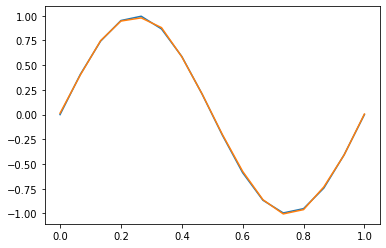

In [28]:
plt.plot(np.linspace(0,1,2**(n_qubits)),np.sin(2*np.pi*x))
plt.plot(np.linspace(0,1,2**(n_qubits)),checkwave(lsin,n_qubits,depth))
plt.show()
#check to see if it correctly found the minimum

In [16]:
## one timestep ##
t = 0.001

def costObj(x):
    return cost(x,lsin)

result = skopt.minimize(costObj, params, bounds, 10000, method='imfil')[0]
## result for one timestep ##

In [24]:
result.optpar
#list of parameters after one timestep

array([2.62170481, 1.10601546, 0.46068662, 4.46348967, 0.        ,
       4.44802869, 0.87097034, 2.71547137, 2.32590366, 6.03521365,
       5.72531867, 3.26136845, 0.40097366, 2.25243055, 0.46121887,
       1.85935592, 2.33122688, 4.30656873, 4.60623241, 5.25151302,
       1.86248834, 1.36207753, 2.3231107 , 1.05169179, 1.93906749,
       4.85183374, 6.28318531, 5.39028795, 3.21249719, 4.11967056,
       4.6466122 , 0.76321749, 4.66578983, 6.28318531, 3.09821972,
       2.30165607, 4.84484754, 6.28318531, 1.62864637, 5.14124371,
       5.10572663, 5.29496875, 5.59269927, 5.11992126, 1.45755943,
       5.50218001, 2.4978156 , 5.97349095, 0.        , 1.64773326,
       4.97645472, 0.36123588, 5.71080762, 6.28318531, 2.15830968,
       4.41815177, 1.94323392, 0.95772912, 3.72066448, 1.47592125,
       1.47891049, 0.76654422, 3.41247098, 4.52571203, 6.28318531,
       0.87636621, 1.14521878, 0.86843491, 5.50543208, 0.62771251,
       3.86249149, 3.14465487, 0.        ])

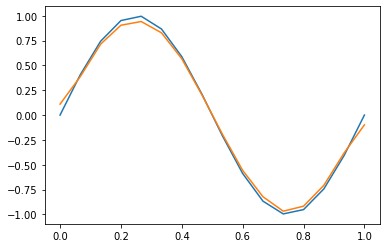

In [22]:
"""
Solution after one timestep, i.e. u(x,0) compared with u(x,0+t)

"""
ltest = result.optpar
x = np.linspace(0,1,2**n_qubits)
plt.plot(x,np.sin(2*np.pi*x))
plt.plot(x,checkwave(ltest,n_qubits,depth))
plt.show()

In [ ]:
"""
The code below can be used to generate a solution from t=0 to t=tend
"""

t=0.001
tend=0.010

numsteps = tend/t

def initobj(p):
    x=np.linspace(0,1,2**n_qubits)
    v = checkwave(p,n_qubits,depth)-np.sin(np.pi*x*2)
    return np.dot(v,v)

result = skopt.minimize(initobj, params, bounds, 10000, method='imfil')[0]
lsin = result.optpar

params = np.zeros(n_params + 1) #generate parameter list
params[0] = np.random.random()*8

for i in range(1,n_params): params[i] = np.random.random()*2*np.pi 
bounds = generateBounds(n_qubits,depth)

results = []
#results[i] contains the optimal set of parameters for the ith timestep

lprev = lsin
for i in range(0,numsteps):
    result = skopt.minimize(cost, params, bounds, 10000, method='imfil')[0]
    lprev = result.optpar
    results.append(lprev)
### END ###